In [ ]:
<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [33]:
# Imports
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

In [34]:
# set data path
# inspect the df
path = './data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'
df = pd.read_csv(path)
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


### Tokenize

In [35]:
# make a new df with only two required columns
reviews_df = df[['reviews.rating', 'reviews.text']].copy()
reviews_df.head()

,reviews.rating,reviews.text
0,3,I order 3 of them and one of the item is bad q...
1,4,Bulk is always the less expensive way to go fo...
2,5,Well they are not Duracell but for the price i...
3,5,Seem to work as well as name brand batteries a...
4,5,These batteries are very long lasting the pric...


In [36]:
# https://radimrehurek.com/gensim/parsing/preprocessing.html
# create a custom stopwords list

from gensim.parsing.preprocessing import preprocess_string
STOPWORDS = set(STOPWORDS).union(set(['amazon', 'tablet', 'kindl', 'batteri']))

# simple tokenizer
def tokenize(text):
    return [token for token in preprocess_string(text) if token not in STOPWORDS]

In [37]:
# creating tokenized_text using the def from above
reviews_df['tokenized_text'] = reviews_df['reviews.text'].apply(lambda text: tokenize(text))
reviews_df.head()

,reviews.rating,reviews.text,tokenized_text
0,3,I order 3 of them and one of the item is bad q...,"[order, item, bad, qualiti, miss, backup, spri..."
1,4,Bulk is always the less expensive way to go fo...,"[bulk, expens, wai, product, like]"
2,5,Well they are not Duracell but for the price i...,"[duracel, price, happi]"
3,5,Seem to work as well as name brand batteries a...,"[work, brand, better, price]"
4,5,These batteries are very long lasting the pric...,"[long, price, great]"


### Get a count of words

In [38]:
from collections import Counter

def count(docs):
    '''This function takes a list of tokenized documents as input and returns
    a dataframe with frequency counts of words in the document set.
    
    # Arguments
        docs: list, tokenized list of documents
        
    # Returns
        wc: dataframe, 
    '''
    
    word_counts = Counter()
    appears_in = Counter()

    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [39]:
wc = count(reviews_df['tokenized_text'])
print(wc.shape)
wc.head(10)

(6461, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
21,great,8192,9466,1.0,0.033938,0.033938,0.289143
82,love,5548,6232,2.0,0.022343,0.056281,0.195821
25,good,5232,5917,3.0,0.021214,0.077495,0.184668
15,price,5160,5495,4.0,0.019701,0.097196,0.182126
7,work,4254,4635,5.0,0.016618,0.113814,0.150148
28,bought,2980,3186,6.0,0.011423,0.125237,0.105181
160,kid,2441,3019,7.0,0.010824,0.136061,0.086157
710,easi,2705,2957,8.0,0.010602,0.146662,0.095475
14,like,2506,2885,9.0,0.010343,0.157006,0.088451
23,bui,2518,2808,10.0,0.010067,0.167073,0.088875


In [ ]:
###  LDA Topic Modelling

In [40]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(reviews_df['tokenized_text'])

In [15]:
id2word.token2id['price']

17

In [16]:
# remove extreme values from the dataset
id2word.filter_extremes(no_below=5, no_above=0.95)

In [17]:
#doc2bow() simply counts the number of occurrences of each distinct word,
#converts the word to its integer word id and returns the result as a sparse vector.

corpus = [id2word.doc2bow(text) for text in reviews_df['tokenized_text']]

In [18]:
corpus[5]

[(18, 2),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 2),
 (35, 1),
 (36, 1)]

In [19]:
# Initailize the LDA
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=42,
                   num_topics = 15,
                   passes=10,
                   workers=12
                  )

In [20]:
lda.print_topics()

[(0,
  '0.033*"app" + 0.030*"book" + 0.027*"read" + 0.023*"store" + 0.022*"like" + 0.018*"good" + 0.018*"ipad" + 0.017*"googl" + 0.014*"pretti" + 0.013*"android"'),
 (1,
  '0.115*"great" + 0.043*"easi" + 0.036*"movi" + 0.031*"watch" + 0.028*"game" + 0.028*"work" + 0.023*"download" + 0.022*"app" + 0.022*"kid" + 0.022*"read"'),
 (2,
  '0.030*"like" + 0.021*"good" + 0.021*"screen" + 0.021*"plai" + 0.020*"game" + 0.019*"year" + 0.019*"old" + 0.019*"better" + 0.017*"ipad" + 0.016*"bought"'),
 (3,
  '0.127*"love" + 0.055*"old" + 0.051*"bought" + 0.051*"year" + 0.038*"great" + 0.031*"gift" + 0.029*"easi" + 0.024*"christma" + 0.024*"kid" + 0.022*"daughter"'),
 (4,
  '0.041*"light" + 0.020*"read" + 0.015*"love" + 0.014*"purchas" + 0.013*"easi" + 0.012*"weight" + 0.012*"case" + 0.012*"charg" + 0.011*"devic" + 0.011*"reader"'),
 (5,
  '0.039*"screen" + 0.026*"read" + 0.022*"size" + 0.021*"like" + 0.012*"easi" + 0.011*"easier" + 0.010*"light" + 0.010*"need" + 0.009*"good" + 0.009*"button"'),
 (6,


In [21]:
# print the topics neatly
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:5]) for t in words]
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
app book read store like

------ Topic 1 ------
great easi movi watch game

------ Topic 2 ------
like good screen plai game

------ Topic 3 ------
love old bought year great

------ Topic 4 ------
light read love purchas easi

------ Topic 5 ------
screen read size like easi

------ Topic 6 ------
good price great valu product

------ Topic 7 ------
great easi nice featur size

------ Topic 8 ------
purchas app son enjoi love

------ Topic 9 ------
read game plai love book

------ Topic 10 ------
work great price long brand

------ Topic 11 ------
bought want time work read

------ Topic 12 ------
kid app game love time

------ Topic 13 ------
great product price love work

------ Topic 14 ------
bui best price purchas bought



### Interpret LDA Results

In [22]:
# Topic Distance Visualization


import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [23]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.195180 -0.031779       1        1  12.799026
14    -0.179737 -0.028494       2        1   9.926958
3      0.173965 -0.089550       3        1   9.123449
6     -0.135812 -0.186609       4        1   7.557419
12     0.172313 -0.037404       5        1   7.465311
5     -0.089556  0.180553       6        1   6.992376
7     -0.033023 -0.011821       7        1   6.692961
4     -0.059527  0.133064       8        1   6.187324
0     -0.009072  0.055358       9        1   5.632346
9      0.141006  0.045872      10        1   5.130307
2      0.045360  0.037725      11        1   4.933873
1      0.066140 -0.077164      12        1   4.930297
13    -0.019863 -0.076189      13        1   4.316199
11     0.022916  0.047703      14        1   4.313665
8      0.100069  0.038735      15        1   3.998496, topic_info=        Term         Freq        Total Category  logprob  loglift
19     great  8910.000000  8910.000000  Default  30.0000  30.0000
76      love  5943.000000  5943.000000  Default  29.0000  29.0000
30      good  5452.000000  5452.000000  Default  28.0000  28.0000
12   product  2290.000000  2290.000000  Default  27.0000  27.0000
16     price  4997.000000  4997.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
231     case    64.563805   930.702698  Topic15  -5.1245   0.5510
11      like    75.000145  2915.472168  Topic15  -4.9747  -0.4410
349     plai    68.725578  1766.413208  Topic15  -5.0621  -0.0273
189    devic    66.296646  1461.054810  Topic15  -5.0980   0.1265
154      kid    68.008331  3198.180664  Topic15  -5.0725  -0.6315

[1161 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
51        1  0.351741     aaa
51        2  0.470222     aaa
51        4  0.048133     aaa
51        6  0.014810     aaa
51        8  0.103671     aaa
...     ...       ...     ...
1667     14  0.021118  youtub
1667     15  0.005279  youtub
926       2  0.841954     yup
2017      6  0.910623  zipper
1201     14  0.926979    zone

[4670 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 15, 4, 7, 13, 6, 8, 5, 1, 10, 3, 2, 14, 12, 9])

In [24]:
# Selecting Optimal Number of Topics

from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        print(f'PASS #{iter_}:')
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })
            print(f'Evaluating Topic Model with {num_topics} topics...')

    return coherence_values

In [25]:
%%time
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                            corpus=corpus,
                                            start=5, 
                                            limit=40, 
                                            step=3,
                                            passes=5)

PASS #0:
Evaluating Topic Model with 5 topics...
Evaluating Topic Model with 8 topics...
Evaluating Topic Model with 11 topics...
Evaluating Topic Model with 14 topics...
Evaluating Topic Model with 17 topics...
Evaluating Topic Model with 20 topics...
Evaluating Topic Model with 23 topics...
Evaluating Topic Model with 26 topics...
Evaluating Topic Model with 29 topics...
Evaluating Topic Model with 32 topics...
Evaluating Topic Model with 35 topics...
Evaluating Topic Model with 38 topics...
PASS #1:
Evaluating Topic Model with 5 topics...
Evaluating Topic Model with 8 topics...
Evaluating Topic Model with 11 topics...
Evaluating Topic Model with 14 topics...
Evaluating Topic Model with 17 topics...
Evaluating Topic Model with 20 topics...
Evaluating Topic Model with 23 topics...
Evaluating Topic Model with 26 topics...
Evaluating Topic Model with 29 topics...
Evaluating Topic Model with 32 topics...
Evaluating Topic Model with 35 topics...
Evaluating Topic Model with 38 topics...
PA

In [26]:
topic_coherence = pd.DataFrame.from_records(coherence_values)
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,5,-2.576949
1,0,8,-2.611921
2,0,11,-2.588592
3,0,14,-2.723728
4,0,17,-2.665787


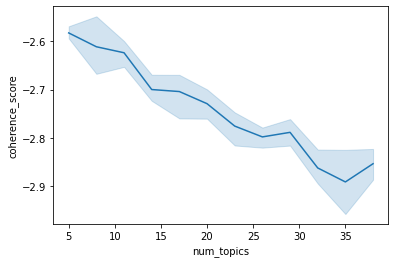

In [27]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling